# Computer Vision 2025 Final Project
## Project 2: **Improving Robustness of Deepfake Detectors through Gradient Regularization**

Najeh Alhalawani (2223737)

# Imports

In [ ]:
!pip install tqdm

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import time
from tqdm import tqdm
from torch.utils.data import Subset
import numpy as np
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, accuracy_score, log_loss, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.cuda.amp import autocast, GradScaler
import cv2
from mtcnn import MTCNN
import glob
import logging
import shutil
from pathlib import Path
from random import random
import torchvision.transforms.functional as TF
from collections import Counter


# Globals

In [ ]:
data_dir = '/content/dataset_combined'

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('./final.log'),
        logging.StreamHandler()
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Utils

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
folders = ['results', 'baseline', 'grad_reg']

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

In [ ]:
class DataHandler:
    def __init__(self, data_dir, batch_size=32, img_size=224):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    def load_data(self):
        train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), transform=self.transform)
        val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'validation'), transform=self.transform)
        test_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'test'), transform=self.transform)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.dataset_stats = {
            'train': self.get_dataset_stats(train_dataset, 'train'),
            'validation': self.get_dataset_stats(val_dataset, 'validation'),
            'test': self.get_dataset_stats(test_dataset, 'test')
        }

        return train_loader, val_loader, test_loader

    def get_dataset_stats(self, dataset, split_name):
        labels = [label for _, label in dataset.samples]
        class_counts = Counter(labels)
        class_names = dataset.classes
        stats = {
            'total_samples': len(labels),
            'class_distribution': {class_names[i]: count for i, count in class_counts.items()}
        }
        return stats

    def print_dataset_stats(self):
        print("\nDataset Statistics:")
        print("="*50)
        for split, stats in self.dataset_stats.items():
            print(f"\n{split.capitalize()} Set:")
            print(f"Total samples: {stats['total_samples']}")
            for class_name, count in stats['class_distribution'].items():
                print(f"{class_name}: {count} samples")
            if len(stats['class_distribution']) == 2:
                fake_count = stats['class_distribution'].get('fake', 0)
                real_count = stats['class_distribution'].get('real', 0)
                print(f"Fake/Real Ratio: {fake_count/(fake_count + real_count)*100:.2f}% / {real_count/(fake_count + real_count)*100:.2f}%")
        print("="*50)


    def augment_real_images_offline(self, num_augments_per_image=2):
        real_dir = os.path.join(self.data_dir, 'train', 'real')
        image_paths = glob.glob(os.path.join(real_dir, '*.jpg')) + glob.glob(os.path.join(real_dir, '*.png'))

        print(f"\nAugmenting {len(image_paths)} real images × {num_augments_per_image} times each...")

        count = 0
        for path in image_paths:
            image = Image.open(path).convert("RGB")
            for i in range(num_augments_per_image):
                aug_image = self.random_augmentation(image)
                aug_filename = f"aug_{count:05d}.jpg"
                aug_path = os.path.join(real_dir, aug_filename)
                aug_image.save(aug_path)
                count += 1

        print(f"Saved {count} augmented images to: {real_dir}")

    def random_augmentation(self, image):
        # Define random transform manually
        image = image.resize((self.img_size, self.img_size))

        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle)
        if random.random() > 0.5:
            brightness = random.uniform(0.8, 1.2)
            image = TF.adjust_brightness(image, brightness)
        if random.random() > 0.5:
            contrast = random.uniform(0.8, 1.2)
            image = TF.adjust_contrast(image, contrast)

        return image

In [ ]:
### Extract frames from FaceForensics+++
def preprocess_frame(frame):
    # convert to grayscale and apply histogram equalization to improve contrast
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    equalized_frame = cv2.equalizeHist(gray_frame)
    # convert back to RGB for MTCNN
    rgb_frame = cv2.cvtColor(equalized_frame, cv2.COLOR_GRAY2RGB)
    return rgb_frame

def process_video(video_path, output_full_dir, output_faces_dir):
    os.makedirs(output_full_dir, exist_ok=True)
    os.makedirs(output_faces_dir, exist_ok=True)
    video_name = Path(video_path).stem

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: could not open video {video_path}")
        return False

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print(f"Error: invalid frame count for {video_path}")
        cap.release()
        return False

    frame_positions = [
        int(total_frames * 0.2),  # 20% of video
        int(total_frames * 0.8)   # 80% of video
    ]

    detector = MTCNN()

    for idx, frame_pos in enumerate(frame_positions, 1):
        # set to the specified frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)

        ret, frame = cap.read()
        if not ret:
            print(f"Error: could not read frame at position {frame_pos} in {video_path}")
            continue

        # save full frame
        full_frame_path = os.path.join(output_full_dir, f"{video_name}_full_{idx*20}.jpg")
        cv2.imwrite(full_frame_path, frame)
        print(f"Saved full frame: {full_frame_path}")

        # preprocess frame for better detection
        rgb_frame = preprocess_frame(frame)

        # detect faces
        faces = detector.detect_faces(rgb_frame)

        if faces:
            for i, face in enumerate(faces):
                x, y, w, h = face['box']
                # ensure bounding box is valid
                if w <= 0 or h <= 0:
                    print(f"Invalid bounding box for face {i+1} at frame {frame_pos} in {video_path}")
                    continue

                # extract face region with padding
                padding = 20
                top = max(0, y - padding)
                left = max(0, x - padding)
                bottom = min(frame.shape[0], y + h + padding)
                right = min(frame.shape[1], x + w + padding)

                # crop face from original frame (not preprocessed, to preserve color)
                face_frame = frame[top:bottom, left:right]

                # check if face frame is valid
                if face_frame.size == 0:
                    print(f"Empty face frame for face {i+1} at frame {frame_pos} in {video_path}")
                    continue

                # resize face to 224x224
                try:
                    face_frame_resized = cv2.resize(face_frame, (224, 224), interpolation=cv2.INTER_AREA)
                except Exception as e:
                    print(f"Error resizing face {i+1} at frame {frame_pos} in {video_path}: {e}")
                    continue

                face_frame_path = os.path.join(output_faces_dir, f"{video_name}_face_{idx*20}_{i+1}.jpg")
                cv2.imwrite(face_frame_path, face_frame_resized)
                print(f"Saved face frame: {face_frame_path} (Face {i+1}, Confidence: {face['confidence']:.2f})")
        else:
            print(f"No faces detected at frame {frame_pos} in {video_path}")

    cap.release()
    return True

def process_videos_in_directory(video_dir, output_full_dir, output_faces_dir, start_from=0):
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv')
    video_list = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir)
                        if os.path.isfile(os.path.join(video_dir, f)) and f.lower().endswith(video_extensions)])

    if not video_list:
        print(f"No videos found in {video_dir}")
        return

    if start_from < 0 or start_from >= len(video_list):
        print(f"Error: start_from index {start_from} is out of range. Valid range: 0 to {len(video_list)-1}")
        return

    for idx, video_path in enumerate(video_list[start_from:], start=start_from):
        print(f"\nProcessing video {idx+1}/{len(video_list)}: {video_path}")
        success = process_video(video_path, output_full_dir, output_faces_dir)
        if not success:
            print(f"Failed to process {video_path}")

# Data

### Download DFFD Dataset

Retrieve the password from the official website

In [ ]:
!wget https://www.cse.msu.edu/computervision/dffd_dataset/stylegan_celeba.zip --no-check-certificate  -P DFFD
!wget https://www.cse.msu.edu/computervision/dffd_dataset/stargan.zip --no-check-certificate  -P DFFD
!wget https://www.cse.msu.edu/computervision/dffd_dataset/stylegan_ffhq.zip --no-check-certificate  -P DFFD
!wget https://www.cse.msu.edu/computervision/dffd_dataset/pggan_v1.zip --no-check-certificate  -P DFFD
!wget https://www.cse.msu.edu/computervision/dffd_dataset/pggan_v2.zip --no-check-certificate  -P DFFD
!wget https://www.cse.msu.edu/computervision/dffd_dataset/ffhq.zip --no-check-certificate  -P DFFD

In [ ]:
!unzip  ./DFFD/stargan.zip -d ./content/
!unzip  ./DFFD/stylegan_celeba.zip -d ./content/
!unzip  ./DFFD/stylegan_ffhq.zip -d ./content/
!unzip  ./DFFD/pggan_v1.zip -d ./content/
!unzip  ./DFFD/pggan_v2.zip -d ./content/
!unzip  ./DFFD/ffhq.zip -d ./content/real/

### Split dataset into fake/real inside train/test/validation folders

In [ ]:
base_dir = './content'

output_base = os.path.join(base_dir, 'dataset_combined')
splits = ['train', 'test', 'validation']
classes = ['fake', 'real']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)

    if folder_name == 'dataset_combined' or not os.path.isdir(folder_path):
        continue

    for split in splits:
        source_split_path = os.path.join(folder_path, split)

        if os.path.exists(source_split_path):
            for file_name in os.listdir(source_split_path):
                src_file = os.path.join(source_split_path, file_name)

                # Determine destination class: real or fake
                if file_name.startswith('R_'):
                    cls = 'real'
                else:
                    cls = 'fake'

                dest_path = os.path.join(output_base, split, cls)
                dst_file = os.path.join(dest_path, file_name)

                if os.path.exists(dst_file):
                    base, ext = os.path.splitext(file_name)
                    count = 1
                    while os.path.exists(dst_file):
                        new_name = f"{base}_{count}{ext}"
                        dst_file = os.path.join(dest_path, new_name)
                        count += 1

                shutil.copy2(src_file, dst_file)

### Analyze Fake/Real Ratio in DFFD Dataset

In [ ]:
data_handler = DataHandler('./content/dataset_combined/')
train_loader, val_loader, test_loader = data_handler.load_data()
data_handler.print_dataset_stats()


Dataset Statistics:

Train Set:
Total samples: 59956
fake: 49956 samples
real: 10000 samples
Fake/Real Ratio: 83.32% / 16.68%

Validation Set:
Total samples: 5997
fake: 4998 samples
real: 999 samples
Fake/Real Ratio: 83.34% / 16.66%

Test Set:
Total samples: 66860
fake: 57860 samples
real: 9000 samples
Fake/Real Ratio: 86.54% / 13.46%


### FaceForencics++ Dataset

In [ ]:
!python download.py -c c23 --server EU2 -d original ./real_videos/Original_Videos_FF

* Extract 4 Frames From Each Video
* Face Detection using MTCNN
* Resize Image To The Bounding Box of The Face
* Save Detected Faces

In [ ]:
video_directory = "./real_videos/Original_Videos_FF/original_sequences/youtube/c23/videos"
output_full_directory = "./real_videos/full/"
output_faces_directory = "./real_videos/faces/"


process_videos_in_directory(video_directory, output_full_directory, output_faces_directory, start_from=0)

### Append Newly Extracted Faces Into The Combined Dataset

In [ ]:
random.seed(42)

new_real_dir = Path("./real_videos/faces/")
dataset_root = Path("./content/dataset_combined/")

all_real_samples = list(new_real_dir.glob("*"))
random.shuffle(all_real_samples)

total = len(all_real_samples)
train_split = int(0.7 * total)
val_split = int(0.15 * total)
test_split = total - train_split - val_split

train_samples = all_real_samples[:train_split]
val_samples = all_real_samples[train_split:train_split + val_split]
test_samples = all_real_samples[train_split + val_split:]

def copy_samples(samples, dest_dir):
    dest_dir.mkdir(parents=True, exist_ok=True)
    for sample in samples:
        shutil.copy(sample, dest_dir / sample.name)

copy_samples(train_samples, dataset_root / "train" / "real")
copy_samples(val_samples, dataset_root / "validation" / "real")
copy_samples(test_samples, dataset_root / "test" / "real")

print(f"✅ Copied {len(train_samples)} to train/real/")
print(f"✅ Copied {len(val_samples)} to validation/real/")
print(f"✅ Copied {len(test_samples)} to test/real/")


✅ Copied 1614 to train/real/
✅ Copied 346 to validation/real/
✅ Copied 347 to test/real/


### Analyze Fake/Real Ratio After Appending FaceForensics++ Real Faces

In [ ]:
data_handler = DataHandler('./content/dataset_combined/')
train_loader, val_loader, test_loader = data_handler.load_data()
data_handler.print_dataset_stats()


Dataset Statistics:

Train Set:
Total samples: 61570
fake: 49956 samples
real: 11614 samples
Fake/Real Ratio: 81.14% / 18.86%

Validation Set:
Total samples: 6343
fake: 4998 samples
real: 1345 samples
Fake/Real Ratio: 78.80% / 21.20%

Test Set:
Total samples: 67207
fake: 57860 samples
real: 9347 samples
Fake/Real Ratio: 86.09% / 13.91%


### Augment Real Training Data

In [ ]:
handler = DataHandler(data_dir='./content/dataset_combined/')
handler.augment_real_images_offline(num_augments_per_image=3)

data_handler = DataHandler('./content/dataset_combined/')
train_loader, val_loader, test_loader = data_handler.load_data()
data_handler.print_dataset_stats()


Augmenting 11614 real images × 3 times each...
Saved 34842 augmented images to: ./content/dataset_combined/train/real

Dataset Statistics:

Train Set:
Total samples: 96412
fake: 49956 samples
real: 46456 samples
Fake/Real Ratio: 51.82% / 48.18%

Validation Set:
Total samples: 6343
fake: 4998 samples
real: 1345 samples
Fake/Real Ratio: 78.80% / 21.20%

Test Set:
Total samples: 67207
fake: 57860 samples
real: 9347 samples
Fake/Real Ratio: 86.09% / 13.91%


### Using the combined dataset (dataset_combined_v2.zip)

In [ ]:
!unzip /data/dataset_combined_v2.zip -d /content/

In [ ]:
!mv /content/content/dataset_combined /content/

In [ ]:
!rm -r /content/content

### Load The Combined Dataset

In [ ]:
# for both baseline and gradient regularization models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'validation'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# Network

In [ ]:
### BASELINE MODEL
model = models.efficientnet_b0(pretrained=True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 205MB/s]


Equation 7

$$
f'_{\theta_{s}}(x) = f_{\theta_{s}}(x)_{\text{norm}}(\sigma_{s} + \Delta\sigma_{s}) + (\mu_{s} + \Delta\mu_{s})
$$

In [ ]:
### GRADIENT REGULARIZATION MODEL

"""
 The Perturbation Injection Module applies the calculated adversarial perturbation
 to the shallow feature statistics, It is the mechanism for creating the perturbed features used in the second pass.
"""
class PerturbationInjectionModule(nn.Module):
    """
    Applies perturbations to the shallow feature statistics.
    """
    def __init__(self):
        super(PerturbationInjectionModule, self).__init__()

    def forward(self, x_norm, mu_s, sigma_s, delta_mu_s, delta_sigma_s):
        # Denormalize the features with perturbed statistics (mean and standard deviation) as per Equation (7)
        x_perturbed = x_norm * (sigma_s + delta_sigma_s) + (mu_s + delta_mu_s)
        return x_perturbed
"""
 Defines the main model architecture, explicitly separating it into shallow and deep parts.
 This separation is crucial for isolating the layers where texture patterns are captured and perturbations are applied.
"""
class DeepfakeDetector(nn.Module):
    """
    The main Deepfake Detector model, wrapping a backbone using EfficientNet.
    """
    def __init__(self, pretrained=True):
        super(DeepfakeDetector, self).__init__()
        base_model = models.efficientnet_b0(pretrained=pretrained)
        # The first few layers capture low-level texture features, these will be perturbed.
        self.shallow_features_extractor = nn.Sequential(*list(base_model.features[:2]))
        # The remaining layers process higher-level features.
        self.deep_features_extractor = nn.Sequential(*list(base_model.features[2:]))
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(base_model.classifier[1].in_features, 2)  # 2 classes: real/fake
        )

    def forward(self, x):
        x = self.shallow_features_extractor(x)
        x = self.deep_features_extractor(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def forward_from_shallow(self, shallow_out):
        """
        A forward pass starting from the output of the shallow layers.
        This is essential for the two-pass algorithm, as it allows us to process both original and perturbed shalllow features
        without re-computing the initial layers.
        """
        x = self.deep_features_extractor(shallow_out)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def compute_statistics(x):
    """
    Computes channel-wise mean and standard deviation for shallow features.
    These statistics are used to represent the image texture patterns.
    """
    mu_s = x.mean(dim=[2, 3], keepdim=True)
    sigma_s = torch.sqrt(x.var(dim=[2, 3], keepdim=True) + 1e-8)  # Add epsilon for stability
    return mu_s, sigma_s

# Train

In [ ]:
### BASELINE MODEL
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in tqdm(loader, desc="training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

    return total_loss / len(loader), correct / len(loader.dataset)

for epoch in range(5):
    train_loss, train_acc = train(model, train_loader)

    print(f"epoch {epoch+1}:")
    print(f"train loss = {train_loss:.4f}, train accuracy = {train_acc:.4f}")

torch.save(model.state_dict(), "baseline/baseline_model_5_combined.pth")  # saving model weights only

### Implementation Pipeline
1. Initialization
   * For each batch of data, start by cleaning any existing gradients from the optimizer.
2. Pass 1: Gradient from Original Data (g1)
   * Perform a forward pass using the original, unperturbed input data to calculate the standard empirial loss, L_original
   * Perform a backward pass on L_original. This computes two things:
      * The gradients of the loss with respect to the model's parameters, which are stored as g1.
      * The gradients of the loss with respect to the shallow feature statistics
3. Perturbation Calculation
   * Use the gradients of the feature statistics mean, std from the previous step to calculate the perturbation vector. This is done by taking a small step of size r in the direction of this gradient as defined in equation (9)
4. Pass 2: Gradient from Perturbed Data (g2)
   * Apply the calculated perturbation to the shallow features of the original input data using the PIM.
   * Perform a forward pass using these new, perturbed features to calculate the perturbed loss L_perturbed.
   * Perform a second backward pass on L_perturbed to compute the gradients of the model's parameters, which are stored as (g2)
5. Combine Gradients and update
   * Manually set the final gradient for each model parameter by combining the stored gradients.
   * Call the optimizer to perform a single update step using this final, combined gradient.

Equation 1

$$
L(x, y, \theta) = \frac{1}{N} \sum_{i=0}^{N-1} \text{CE}(f_{\theta_{d}}(f_{\theta_{s}}(x_{i})), y_{i})
$$

Equation 6

$$
f_{\theta_{s}}(x)_{\text{norm}}=\frac{f_{\theta_{s}}(x)-\mu_{s}}{\sigma_{s}}
$$

Equation 9

$$
\Delta l = r \frac{\nabla_{\mu_{s},\sigma_{s}}L(f_{\theta_{s}}(x),y,\theta_{d})}{\|\nabla_{\mu_{s},\sigma_{s}}L(f_{\theta_{s}}(x),y,\theta_{d})\|_{2}}
$$

Equation 12

$$
\min_{\theta} (1-\alpha)L(x, y, \theta) + \alpha L(f'_{\theta_{s}}(x), y, \theta_{d})
$$

In [ ]:
### GRADIENT REGULARIZATION MODEL
R_SCALAR = 0.05     # Approximation scalar 'r' controls the magnitude of the perturbation
ALPHA_COEFF = 1.0   # Balance coefficient 'α' balance coefficient for the two loss components
EPOCHS = 10         # Number of training epochs
LEARNING_RATE = 0.001

model = DeepfakeDetector(pretrained=True).to(device)
pim = PerturbationInjectionModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()  # Initialize GradScaler for AMP

logging.info(f"Hyperparameters: epochs={EPOCHS}, lr={LEARNING_RATE}, r={R_SCALAR}, alpha={ALPHA_COEFF}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}")):
        inputs, labels = inputs.to(device), labels.to(device)

        """ Step 1: First Forward Pass for g1
        This pass calculates the standard empirical loss and computes the gradients needed for both
        the model update g1 and the perturbation calculation.
        """
        optimizer.zero_grad()
        with autocast():  # Enable mixed precision
            # Get shallow features
            shallow_out = model.shallow_features_extractor(inputs)

            # Compute the feature statistics (μ_s, σ_s) that represent image texture.
            mu_s, sigma_s = compute_statistics(shallow_out)

            """ Make sure statistics require gradients
            This makes them leaf nodes, allowing us to get their gradients explicitly.
            """
            mu_s = mu_s.detach().requires_grad_(True)
            sigma_s = sigma_s.detach().requires_grad_(True)

            # First forward pass
            # Apply equation (6) to normalize the shallow features
            x_norm = (shallow_out - mu_s) / (sigma_s + 1e-8)
            reconstructed_shallow = x_norm * sigma_s + mu_s

            # Calculate the standard empirical loss on the original unperturbed data
            # Equation (1)
            outputs_original = model.forward_from_shallow(reconstructed_shallow)
            L_original = criterion(outputs_original, labels)

        """Scale loss and compute gradients
        The first backward pass. It computes the gradient of the loss w.r.t all parameters in the graph.
        retain_graph=True is crucial as it keeps the computation graph intact for the second backward pass
        """
        scaler.scale(L_original).backward(retain_graph=True)

        """
        Explicitly extract the gradients of the loss w.r.t the statistics (μ_s, σ_s).
        These gradients indicate the direction of vulnerability of the model to texture changes.
        """
        grad_mu_s, grad_sigma_s = torch.autograd.grad(
            outputs=L_original,
            inputs=[mu_s, sigma_s],
            retain_graph=True,
            create_graph=False
        )

        # Store gradients g1: the gradients of the model parameters after the first backward pass.
        # g1: gradient of the original loss
        g1 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
              for p in model.parameters()]

        """
        This computes the actual perturbation vector based on the gradients found in the previous step.
        """
        grad_vec = torch.cat([grad_mu_s.flatten(), grad_sigma_s.flatten()])
        norm_grad = torch.norm(grad_vec)

        # Step 2: Compute Perturbations by taking a small step 'r' in the direction of the gradients
        # Equation (9)
        if norm_grad > 1e-8:
            delta_l = R_SCALAR * grad_vec / norm_grad
        else:
            delta_l = torch.zeros_like(grad_vec)

        # Reshape perturbation vector back to the original statistics shape (mean, std)
        delta_mu_s = delta_l[:mu_s.numel()].view_as(mu_s)
        delta_sigma_s = delta_l[mu_s.numel():].view_as(sigma_s)

        """ Step 3: Second Forward/Backward Pass for g2
        This pass calculates the loss and gradient on the perturbed shallow features.
        """
        optimizer.zero_grad()
        with autocast():
            # normalize the original shallow features
            x_norm = (shallow_out.detach() - mu_s.detach()) / (sigma_s.detach() + 1e-8)
            # use PIM to create the perturbed shallow features
            perturbed_shallow_out = pim(x_norm, mu_s.detach(), sigma_s.detach(), delta_mu_s, delta_sigma_s)

            """
            Calculate the loss on the perturbed data
            Loss function from Equation 12
            """
            outputs_perturbed = model.forward_from_shallow(perturbed_shallow_out)
            L_perturbed = criterion(outputs_perturbed, labels)

        """ Scale loss and compute gradients
        This calculates the gradients of the model parameters w.r.t the perturbed loss.
        """
        scaler.scale(L_perturbed).backward()

        # Store gradients g2 from the second pass.
        # g2: gradient of the perturbed loss
        g2 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
              for p in model.parameters()]

        # Step 4: Combine Gradients and Update Weights
        optimizer.zero_grad()
        with torch.no_grad():
            for p_idx, p in enumerate(model.parameters()):
                """
                set the final gradient for each parameter using the weighed combination of g1 and g2
                this update rule encourages both accuracy (from g1) and robustness (from g2)
                """
                combined_grad = (1 - ALPHA_COEFF) * g1[p_idx] + ALPHA_COEFF * g2[p_idx]
                p.grad = combined_grad

        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()

        """
        Calculate the combined loss
        """
        combined_loss = (1 - ALPHA_COEFF) * L_original.item() + ALPHA_COEFF * L_perturbed.item()
        running_loss += combined_loss


        if (i + 1) % 50 == 0:
            logging.info(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {combined_loss:.4f}")

    avg_train_loss = running_loss / len(train_loader)

    logging.info(f"\nEpoch {epoch+1}")
    logging.info(f"Train Loss: {avg_train_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 2 == 0:
        save_path = f'grad_reg/model_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), save_path)
        logging.info(f"Model saved to '{save_path}'")

torch.save(model.state_dict(), 'grad_reg/final-full.pth')
logging.info("Final model saved to 'final-full.pth'")


# Evaluation

## Model Evaluation

### Baseline Model

In [ ]:
### BASELINE MODEL
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model.load_state_dict(torch.load("baseline/baseline_model_5_combined.pth", map_location=torch.device('cpu'))) # loading model weights

model.eval()
model = model.to(device)

def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1 (deepfake)
            _, preds = torch.max(outputs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    class_names = ["real", "deepfake"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.title("confusion matrix")
    plt.tight_layout()
    plt.show()

    print("\nclassification:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"test accuracy: {accuracy:.6f}")

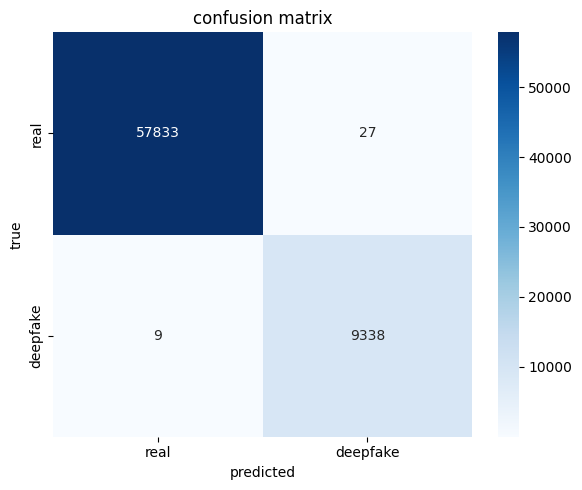


classification:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     57860
    deepfake       1.00      1.00      1.00      9347

    accuracy                           1.00     67207
   macro avg       1.00      1.00      1.00     67207
weighted avg       1.00      1.00      1.00     67207

test accuracy: 0.999464


In [ ]:
evaluate_with_metrics(model, test_loader)

### Gradient Regularization Model

In [ ]:
### GRADIENT REGULARIZATION MODEL
def evaluate_model(model, data_loader, criterion, phase='val'):
    model.eval()
    y_true, y_scores = [], []
    total_loss = 0.0
    scaler = GradScaler()  # Initialize GradScaler for AMP
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"Evaluating {phase}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():  # Enable mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            total_loss += loss.item()

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    auc = roc_auc_score(y_true, y_scores)
    logloss = log_loss(y_true, y_scores)
    y_pred = np.round(y_scores)
    f1 = f1_score(y_true, y_pred)
    return avg_loss, auc, logloss, f1

In [ ]:
criterion = nn.CrossEntropyLoss()
model = DeepfakeDetector(pretrained=False).to(device)
model.load_state_dict(torch.load("grad_reg/model_epoch_6.pth", map_location=device))
model = model.to(device)
avg_test_loss, test_auc, test_logloss, test_f1 = evaluate_model(model, test_loader, criterion, phase='test')

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test LogLoss: {test_logloss:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

<ipython-input-15-1006374996>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for AMP
Evaluating test:   0%|          | 0/2101 [00:00<?, ?it/s]<ipython-input-15-1006374996>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Test Loss: 0.0029
Test AUC: 1.0000
Test LogLoss: 0.0029
Test F1-Score: 0.9968


## Adversarial Evaluation

In [ ]:
def fgsm_attack(image, label, model, epsilon):
    image = image.clone().detach().to(device).requires_grad_(True)
    label = label.to(device)
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    perturbed_image = image + epsilon * image.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

In [ ]:
def pgd_attack(model, images, labels, epsilon, alpha, iters):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad_(True)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad()
        loss.backward()

        # Step in the direction of the gradient
        adv_images = images + alpha * images.grad.sign()

        # Project back to epsilon-ball and clip pixel values
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, 0, 1).detach()

    return images


In [ ]:
def evaluate_adversarial(model, loader, attack_type, epsilon, pgd_steps=None, alpha=None, save_path=None):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    desc = f"{attack_type} epsilon={epsilon:.4f}"
    loop = tqdm(loader, desc=desc, leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        if attack_type == "FGSM":
            adv_images = fgsm_attack(images, labels, model, epsilon)
        elif attack_type == "PGD":
            adv_images = pgd_attack(model, images, labels, epsilon, alpha, pgd_steps)
        else:
            raise ValueError("Unknown attack type")

        with torch.no_grad():
            outputs = model(adv_images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of class 1

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

        loop.set_postfix(acc=correct / total)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0

    print(f"{attack_type} epsilon: {epsilon:.4f}, accuracy: {acc:.4f}, F1 Score: {f1:.4f}, AUC Score: {auc:.4f}")

    if save_path:
        torch.save({
            'epsilon': epsilon,
            'labels': torch.tensor(all_labels),
            'preds': torch.tensor(all_preds),
            'probs': torch.tensor(all_probs),
        }, save_path)
        print(f"Saved to: {save_path}")

    return acc, f1, auc, all_labels, all_preds, all_probs

In [ ]:
def evaluate_model_attacks(checkpoint_path, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if "baseline" in checkpoint_path:
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    else:
        model = DeepfakeDetector(pretrained=True)


    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()

    fgsm_epsilons = [0.001, 0.005, 0.01, 0.02]
    pgd_epsilons = [0.0001, 0.0005, 0.001]
    pgd_steps = 5

    print(f"\nEvaluating attacks on {model_name}")

    for eps in fgsm_epsilons:
        save_path = f"{model_name}_fgsm_eps_{eps:.4f}.pth"
        evaluate_adversarial(model, test_loader, "FGSM", eps, save_path=save_path)

    for eps in pgd_epsilons:
        alpha = eps / pgd_steps
        save_path = f"{model_name}_pgd_eps_{eps:.4f}.pth"
        evaluate_adversarial(model, test_loader, "PGD", eps, pgd_steps=pgd_steps, alpha=alpha, save_path=save_path)

In [ ]:
evaluate_model_attacks("baseline/baseline_model_5_combined.pth", "baseline") # baseline model
evaluate_model_attacks("grad_reg/model_epoch_6.pth", "grad_reg") # model with gradient regularization

# Ablation Study

### Perturbation Layers
Perturbation on the first three layers

In [ ]:
class DeepfakeDetector_3(nn.Module):
    """
    The main Deepfake Detector model, wrapping a backbone using EfficientNet.
    """
    def __init__(self, pretrained=True):
        super(DeepfakeDetector_3, self).__init__()
        base_model = models.efficientnet_b0(pretrained=pretrained)
        # The first few layers capture low-level texture features, these will be perturbed.
        self.shallow_features_extractor = nn.Sequential(*list(base_model.features[:3])) # First three layers
        # The remaining layers process higher-level features.
        self.deep_features_extractor = nn.Sequential(*list(base_model.features[3:])) # First three layers
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(base_model.classifier[1].in_features, 2)  # 2 classes: real/fake
        )

    def forward(self, x):
        x = self.shallow_features_extractor(x)
        x = self.deep_features_extractor(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def forward_from_shallow(self, shallow_out):
        """
        A forward pass starting from the output of the shallow layers.
        This is essential for the two-pass algorithm, as it allows us to process both original and perturbed shalllow features
        without re-computing the initial layers.
        """
        x = self.deep_features_extractor(shallow_out)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def compute_statistics(x):
    """
    Computes channel-wise mean and standard deviation for shallow features.
    These statistics are used to represent the image texture patterns.
    """
    mu_s = x.mean(dim=[2, 3], keepdim=True)
    sigma_s = torch.sqrt(x.var(dim=[2, 3], keepdim=True) + 1e-8)  # Add epsilon for stability
    return mu_s, sigma_s

In [ ]:
### GRADIENT REGULARIZATION MODEL
R_SCALAR = 0.05     # Approximation scalar 'r' controls the magnitude of the perturbation
ALPHA_COEFF = 1.0   # Balance coefficient 'α' balance coefficient for the two loss components
EPOCHS = 10         # Number of training epochs
LEARNING_RATE = 0.001

model = DeepfakeDetector_3(pretrained=True).to(device)
pim = PerturbationInjectionModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()  # Initialize GradScaler for AMP

logging.info(f"Hyperparameters: epochs={EPOCHS}, lr={LEARNING_RATE}, r={R_SCALAR}, alpha={ALPHA_COEFF}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}")):
        inputs, labels = inputs.to(device), labels.to(device)

        """ Step 1: First Forward Pass for g1
        This pass calculates the standard empirical loss and computes the gradients needed for both
        the model update g1 and the perturbation calculation.
        """
        optimizer.zero_grad()
        with autocast():  # Enable mixed precision
            # Get shallow features
            shallow_out = model.shallow_features_extractor(inputs)

            # Compute the feature statistics (μ_s, σ_s) that represent image texture.
            mu_s, sigma_s = compute_statistics(shallow_out)

            """ Make sure statistics require gradients
            This makes them leaf nodes, allowing us to get their gradients explicitly.
            """
            mu_s = mu_s.detach().requires_grad_(True)
            sigma_s = sigma_s.detach().requires_grad_(True)

            # First forward pass
            # Apply equation (6) to normalize the shallow features
            x_norm = (shallow_out - mu_s) / (sigma_s + 1e-8)
            reconstructed_shallow = x_norm * sigma_s + mu_s

            # Calculate the standard empirical loss on the original unperturbed data
            # Equation (1)
            outputs_original = model.forward_from_shallow(reconstructed_shallow)
            L_original = criterion(outputs_original, labels)

        """Scale loss and compute gradients
        The first backward pass. It computes the gradient of the loss w.r.t all parameters in the graph.
        retain_graph=True is crucial as it keeps the computation graph intact for the second backward pass
        """
        scaler.scale(L_original).backward(retain_graph=True)

        """
        Explicitly extract the gradients of the loss w.r.t the statistics (μ_s, σ_s).
        These gradients indicate the direction of vulnerability of the model to texture changes.
        """
        grad_mu_s, grad_sigma_s = torch.autograd.grad(
            outputs=L_original,
            inputs=[mu_s, sigma_s],
            retain_graph=True,
            create_graph=False
        )

        # Store gradients g1: the gradients of the model parameters after the first backward pass.
        # g1: gradient of the original loss
        g1 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
              for p in model.parameters()]

        """
        This computes the actual perturbation vector based on the gradients found in the previous step.
        """
        grad_vec = torch.cat([grad_mu_s.flatten(), grad_sigma_s.flatten()])
        norm_grad = torch.norm(grad_vec)

        # Step 2: Compute Perturbations by taking a small step 'r' in the direction of the gradients
        # Equation (9)
        if norm_grad > 1e-8:
            delta_l = R_SCALAR * grad_vec / norm_grad
        else:
            delta_l = torch.zeros_like(grad_vec)

        # Reshape perturbation vector back to the original statistics shape (mean, std)
        delta_mu_s = delta_l[:mu_s.numel()].view_as(mu_s)
        delta_sigma_s = delta_l[mu_s.numel():].view_as(sigma_s)

        """ Step 3: Second Forward/Backward Pass for g2
        This pass calculates the loss and gradient on the perturbed shallow features.
        """
        optimizer.zero_grad()
        with autocast():
            # normalize the original shallow features
            x_norm = (shallow_out.detach() - mu_s.detach()) / (sigma_s.detach() + 1e-8)
            # use PIM to create the perturbed shallow features
            perturbed_shallow_out = pim(x_norm, mu_s.detach(), sigma_s.detach(), delta_mu_s, delta_sigma_s)

            """
            Calculate the loss on the perturbed data
            Loss function from Equation 12
            """
            outputs_perturbed = model.forward_from_shallow(perturbed_shallow_out)
            L_perturbed = criterion(outputs_perturbed, labels)

        """ Scale loss and compute gradients
        This calculates the gradients of the model parameters w.r.t the perturbed loss.
        """
        scaler.scale(L_perturbed).backward()

        # Store gradients g2 from the second pass.
        # g2: gradient of the perturbed loss
        g2 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
              for p in model.parameters()]

        # Step 4: Combine Gradients and Update Weights
        optimizer.zero_grad()
        with torch.no_grad():
            for p_idx, p in enumerate(model.parameters()):
                """
                set the final gradient for each parameter using the weighed combination of g1 and g2
                this update rule encourages both accuracy (from g1) and robustness (from g2)
                """
                combined_grad = (1 - ALPHA_COEFF) * g1[p_idx] + ALPHA_COEFF * g2[p_idx]
                p.grad = combined_grad

        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()

        """
        Calculate the combined loss
        """
        combined_loss = (1 - ALPHA_COEFF) * L_original.item() + ALPHA_COEFF * L_perturbed.item()
        running_loss += combined_loss


        if (i + 1) % 50 == 0:
            logging.info(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {combined_loss:.4f}")

    avg_train_loss = running_loss / len(train_loader)

    logging.info(f"\nEpoch {epoch+1}")
    logging.info(f"Train Loss: {avg_train_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 2 == 0:
        save_path = f'grad_reg/model_epoch_{epoch+1}_3.pth'
        torch.save(model.state_dict(), save_path)
        logging.info(f"Model saved to '{save_path}'")

torch.save(model.state_dict(), 'grad_reg/final-full-3.pth')
logging.info("Final model saved to 'final-full-3.pth'")


### Perturbation Magnitude and Balance Coefficient

In [ ]:
# Ablation study parameters
R_SCALARS = [0.05, 0.1]
ALPHA_COEFFS = [1.0, 0.75]
EPOCHS = 5
LEARNING_RATE = 0.001
results = []

# Create a directory for ablation study outputs
os.makedirs("ablation_study", exist_ok=True)

# Ablation study loop
for r in R_SCALARS:
    for alpha in ALPHA_COEFFS:
        # Set up logging for this combination
        log_dir = f"ablation_study/r_{r}_alpha_{alpha}"
        os.makedirs(log_dir, exist_ok=True)
        logging.basicConfig(
            filename=f"{log_dir}/training.log",
            level=logging.INFO,
            format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # Log hyperparameters
        logging.info(f"Starting training with r={r}, alpha={alpha}")
        logging.info(f"Hyperparameters: epochs={EPOCHS}, lr={LEARNING_RATE}, r={r}, alpha={alpha}")

        # Initialize model, optimizer, and other components
        model = DeepfakeDetector(pretrained=True).to(device)
        pim = PerturbationInjectionModule().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
        scaler = GradScaler()

        # Training loop
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}")):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with autocast():
                    shallow_out = model.shallow_features_extractor(inputs)
                    mu_s, sigma_s = compute_statistics(shallow_out)
                    mu_s = mu_s.detach().requires_grad_(True)
                    sigma_s = sigma_s.detach().requires_grad_(True)
                    x_norm = (shallow_out - mu_s) / (sigma_s + 1e-8)
                    reconstructed_shallow = x_norm * sigma_s + mu_s
                    outputs_original = model.forward_from_shallow(reconstructed_shallow)
                    L_original = criterion(outputs_original, labels)

                scaler.scale(L_original).backward(retain_graph=True)
                grad_mu_s, grad_sigma_s = torch.autograd.grad(
                    outputs=L_original,
                    inputs=[mu_s, sigma_s],
                    retain_graph=True,
                    create_graph=False
                )
                g1 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
                    for p in model.parameters()]

                grad_vec = torch.cat([grad_mu_s.flatten(), grad_sigma_s.flatten()])
                norm_grad = torch.norm(grad_vec)
                if norm_grad > 1e-8:
                    delta_l = r * grad_vec / norm_grad
                else:
                    delta_l = torch.zeros_like(grad_vec)

                delta_mu_s = delta_l[:mu_s.numel()].view_as(mu_s)
                delta_sigma_s = delta_l[mu_s.numel():].view_as(sigma_s)

                optimizer.zero_grad()
                with autocast():
                    x_norm = (shallow_out.detach() - mu_s.detach()) / (sigma_s.detach() + 1e-8)
                    perturbed_shallow_out = pim(x_norm, mu_s.detach(), sigma_s.detach(), delta_mu_s, delta_sigma_s)
                    outputs_perturbed = model.forward_from_shallow(perturbed_shallow_out)
                    L_perturbed = criterion(outputs_perturbed, labels)

                scaler.scale(L_perturbed).backward()
                g2 = [p.grad.clone() if p.grad is not None else torch.zeros_like(p)
                    for p in model.parameters()]

                optimizer.zero_grad()
                with torch.no_grad():
                    for p_idx, p in enumerate(model.parameters()):
                        combined_grad = (1 - alpha) * g1[p_idx] + alpha * g2[p_idx]
                        p.grad = combined_grad

                scaler.step(optimizer)
                scaler.update()

                combined_loss = (1 - alpha) * L_original.item() + alpha * L_perturbed.item()
                running_loss += combined_loss

                if (i + 1) % 50 == 0:
                    logging.info(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {combined_loss:.4f}")

            avg_train_loss = running_loss / len(train_loader)
            logging.info(f"\nEpoch {epoch+1}")
            logging.info(f"Train Loss: {avg_train_loss:.4f}")

            if epoch == 0 or (epoch + 1) % 2 == 0:
                save_path = f"{log_dir}/model_epoch_{epoch+1}.pth"
                torch.save(model.state_dict(), save_path)
                logging.info(f"Model saved to '{save_path}'")

# Save final model
final_model_path = f"{log_dir}/final-full.pth"
torch.save(model.state_dict(), final_model_path)
logging.info(f"Final model saved to '{final_model_path}'")

# Evaluate the model
model.load_state_dict(torch.load(final_model_path, map_location=device))
model = model.to(device)
avg_test_loss, test_auc, test_logloss, test_f1 = evaluate_model(model, test_loader, criterion, phase='test')

# Log evaluation results
logging.info(f"Test Loss: {avg_test_loss:.4f}")
logging.info(f"Test AUC: {test_auc:.4f}")
logging.info(f"Test LogLoss: {test_logloss:.4f}")
logging.info(f"Test F1-Score: {test_f1:.4f}")

# Store results
results.append({
    'r': r,
    'alpha': alpha,
    'test_loss': avg_test_loss,
    'test_auc': test_auc,
    'test_logloss': test_logloss,
    'test_f1': test_f1
})

# Print results table
print("\nAblation Study Results:")
print("=" * 80)
print(f"{'r':<8}{'α':<8}{'Test Loss':<12}{'Test AUC':<12}{'Test LogLoss':<14}{'Test F1':<12}")
print("-" * 80)
for result in results:
    print(f"{result['r']:<8.2f}{result['alpha']:<8.2f}{result['test_loss']:<12.4f}{result['test_auc']:<12.4f}"
          f"{result['test_logloss']:<14.4f}{result['test_f1']:<12.4f}")
print("=" * 80)

In [ ]:
evaluate_model_attacks("ablation_study/r_0.1_alpha_0.75/final-full.pth", "r_0.1_alpha_0.75") # model with gradient regularization
evaluate_model_attacks("ablation_study/r_0.1_alpha_1.0//final-full.pth", "r_0.1_alpha_1.0") # model with gradient regularization
evaluate_model_attacks("ablation_study/r_0.05_alpha_0.75/final-full.pth", "r_0.05_alpha_0.75") # model with gradient regularization
evaluate_model_attacks("ablation_study/r_0.05_alpha_1.0//final-full.pth", "r_0.05_alpha_1.0") # model with gradient regularization